In [ ]:
!kaggle datasets download -d linjustin/train-val-test-tcga-coad-msi-mss

Dataset URL: https://www.kaggle.com/datasets/linjustin/train-val-test-tcga-coad-msi-mss
License(s): CC0-1.0
100% 5.46G/5.48G [01:13<00:00, 75.9MB/s]
100% 5.48G/5.48G [01:13<00:00, 80.3MB/s]


In [ ]:
!unzip /content/train-val-test-tcga-coad-msi-mss.zip

Streaming output truncated to the last 5000 lines.
  inflating: tcga_coad_msi_mss/val/MSS/blk-TVIAFRVYTSKM-TCGA-DT-5265-01Z-00-DX1.jpg  
  inflating: tcga_coad_msi_mss/val/MSS/blk-TVICQKERTHTY-TCGA-A6-A56B-01Z-00-DX1.jpg  
  inflating: tcga_coad_msi_mss/val/MSS/blk-TVIGMWLQYTRV-TCGA-CA-6718-01Z-00-DX1.jpg  
  inflating: tcga_coad_msi_mss/val/MSS/blk-TVIICKTKYDVG-TCGA-F4-6806-01Z-00-DX1.jpg  
  inflating: tcga_coad_msi_mss/val/MSS/blk-TVISHWMNKISA-TCGA-DM-A28F-01Z-00-DX1.jpg  
  inflating: tcga_coad_msi_mss/val/MSS/blk-TVKEPHKCTENR-TCGA-AF-6136-01Z-00-DX1.jpg  
  inflating: tcga_coad_msi_mss/val/MSS/blk-TVKEPNDIMKPF-TCGA-AD-A5EK-01Z-00-DX1.jpg  
  inflating: tcga_coad_msi_mss/val/MSS/blk-TVKPHKRWSCTI-TCGA-AY-A71X-01Z-00-DX1.jpg  
  inflating: tcga_coad_msi_mss/val/MSS/blk-TVKRANHGRSLN-TCGA-AY-A71X-01Z-00-DX1.jpg  
  inflating: tcga_coad_msi_mss/val/MSS/blk-TVKRHEALVDNN-TCGA-CM-5344-01Z-00-DX1.jpg  
  inflating: tcga_coad_msi_mss/val/MSS/blk-TVKWDPEGESKV-TCGA-AY-5543-01Z-00-DX1.jpg  
  i

In [ ]:
# Import necessary libraries
import os
import pathlib
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Conv2D, Flatten, Dropout,
                                     MaxPooling2D, Activation, BatchNormalization)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print('TensorFlow Version: ', tf.__version__)
print('GPU Available: ', tf.test.is_gpu_available())
print('Using GPU: ', tf.config.experimental.list_physical_devices('GPU'))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


TensorFlow Version:  2.17.1
GPU Available:  True
Using GPU:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load data

In [ ]:
PATH = '/content/tcga_coad_msi_mss'
train_dir = os.path.join(PATH, 'train')
val_dir = os.path.join(PATH, 'val')
test_dir = os.path.join(PATH, 'test')

train_msimut_dir = os.path.join(train_dir, 'MSIMUT')
train_mss_dir = os.path.join(train_dir, 'MSS')
val_msimut_dir = os.path.join(val_dir, 'MSIMUT')
val_mss_dir = os.path.join(val_dir, 'MSS')
test_msimut_dir = os.path.join(test_dir, 'MSIMUT')
test_mss_dir = os.path.join(test_dir, 'MSS')

In [ ]:
# Check how many images are in each directory
num_msimut_train, num_mss_train = len(os.listdir(train_msimut_dir)), len(os.listdir(train_mss_dir))

num_msimut_val, num_mss_val = len(os.listdir(val_msimut_dir)), len(os.listdir(val_mss_dir))

num_msimut_test, num_mss_test = len(os.listdir(test_msimut_dir)), len(os.listdir(test_mss_dir))

total_train = num_msimut_train + num_mss_train
total_val = num_msimut_val + num_mss_val
total_test = num_msimut_test + num_mss_test

print('Total training MSIMUT images: ', num_msimut_train)
print('Total training MSS images: ', num_mss_train)
print('Total validation MSIMUT images: ', num_msimut_val)
print('Total validation MSS images: ', num_mss_val)
print('Total testing MSIMUT images: ', num_msimut_test)
print('Total testing MSS images: ', num_mss_test)
print('---------------------------------')
print('Total training images: ', total_train)
print('Total validation images: ', total_val)
print('Total testing images: ', total_test)

Total training MSIMUT images:  60031
Total training MSS images:  93818
Total validation MSIMUT images:  7503
Total validation MSS images:  11727
Total testing MSIMUT images:  7505
Total testing MSS images:  11728
---------------------------------
Total training images:  153849
Total validation images:  19230
Total testing images:  19233


In [ ]:
import os
import random
import shutil

# Define the root path for your dataset
PATH = '/content/tcga_coad_msi_mss'

# Define the directories
train_dir = os.path.join(PATH, 'train')
val_dir = os.path.join(PATH, 'val')
test_dir = os.path.join(PATH, 'test')

train_msimut_dir = os.path.join(train_dir, 'MSIMUT')
train_mss_dir = os.path.join(train_dir, 'MSS')
val_msimut_dir = os.path.join(val_dir, 'MSIMUT')
val_mss_dir = os.path.join(val_dir, 'MSS')
test_msimut_dir = os.path.join(test_dir, 'MSIMUT')
test_mss_dir = os.path.join(test_dir, 'MSS')

# Subset directories
train_msimut_dir_subset = os.path.join(PATH, 'train_subset', 'MSIMUT')
train_mss_dir_subset = os.path.join(PATH, 'train_subset', 'MSS')
val_msimut_dir_subset = os.path.join(PATH, 'val_subset', 'MSIMUT')
val_mss_dir_subset = os.path.join(PATH, 'val_subset', 'MSS')
test_msimut_dir_subset = os.path.join(PATH, 'test_subset', 'MSIMUT')
test_mss_dir_subset = os.path.join(PATH, 'test_subset', 'MSS')

# Function to create a subset of the dataset
def create_subset(source_dir, dest_dir, num_images):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    # List all image files in the source directory
    if not os.path.exists(source_dir):
        print(f"Source directory does not exist: {source_dir}")
        return

    image_files = os.listdir(source_dir)

    # Randomly sample the desired number of images
    sampled_files = random.sample(image_files, min(len(image_files), num_images))

    # Copy the sampled images to the destination directory
    for file in sampled_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(dest_dir, file))
    print(f"Subset created for {source_dir} -> {dest_dir} with {len(sampled_files)} images")

# Verify the source directories exist
directories = [train_msimut_dir, train_mss_dir, val_msimut_dir, val_mss_dir, test_msimut_dir, test_mss_dir]

for directory in directories:
    if not os.path.exists(directory):
        print(f"Directory does not exist: {directory}")
    else:
        print(f"Directory exists: {directory}")

# Create subsets (adjust number of images as needed)
num_images = 1500

create_subset(train_msimut_dir, train_msimut_dir_subset, num_images)
create_subset(train_mss_dir, train_mss_dir_subset, num_images)
create_subset(val_msimut_dir, val_msimut_dir_subset, num_images)
create_subset(val_mss_dir, val_mss_dir_subset, num_images)
create_subset(test_msimut_dir, test_msimut_dir_subset, num_images)
create_subset(test_mss_dir, test_mss_dir_subset, num_images)

print("Subset creation completed!")


Directory exists: /content/tcga_coad_msi_mss/train/MSIMUT
Directory exists: /content/tcga_coad_msi_mss/train/MSS
Directory exists: /content/tcga_coad_msi_mss/val/MSIMUT
Directory exists: /content/tcga_coad_msi_mss/val/MSS
Directory exists: /content/tcga_coad_msi_mss/test/MSIMUT
Directory exists: /content/tcga_coad_msi_mss/test/MSS
Subset created for /content/tcga_coad_msi_mss/train/MSIMUT -> /content/tcga_coad_msi_mss/train_subset/MSIMUT with 1500 images
Subset created for /content/tcga_coad_msi_mss/train/MSS -> /content/tcga_coad_msi_mss/train_subset/MSS with 1500 images
Subset created for /content/tcga_coad_msi_mss/val/MSIMUT -> /content/tcga_coad_msi_mss/val_subset/MSIMUT with 1500 images
Subset created for /content/tcga_coad_msi_mss/val/MSS -> /content/tcga_coad_msi_mss/val_subset/MSS with 1500 images
Subset created for /content/tcga_coad_msi_mss/test/MSIMUT -> /content/tcga_coad_msi_mss/test_subset/MSIMUT with 1500 images
Subset created for /content/tcga_coad_msi_mss/test/MSS -> /

In [ ]:
# Set up variables for pre-processing
batch_size = 64
epochs = 5
IMG_HEIGHT = 224
IMG_WIDTH = 224

Class names:  ['MSIMUT' 'MSS']
Found 153849 images belonging to 2 classes.


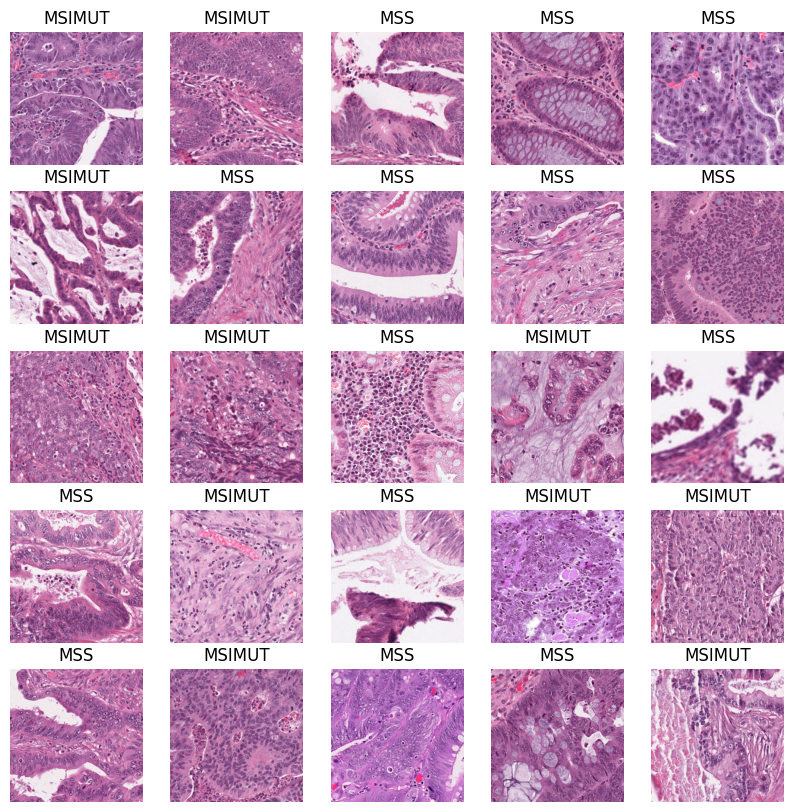

In [ ]:
# Visualize some images
train_root = pathlib.Path(train_dir)
class_names = sorted([j.name.split('/')[-1] for j in train_root.iterdir()])
class_names = np.array(class_names)
print('Class names: ', class_names)

img_gen = ImageDataGenerator(rescale = 1./255)
sample_train_data_gen = img_gen.flow_from_directory(batch_size = batch_size,
                                                    directory = train_dir,
                                                    shuffle = True,
                                                    target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                    classes = list(class_names))

sample_images, sample_labels = next(sample_train_data_gen)

def show_batch(img_batch, label_batch):
    plt.figure(figsize = (10, 10))
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(sample_images[i])
        plt.title(class_names[sample_labels[i] == 1][0])
        plt.axis('off')

show_batch(sample_images, sample_labels)

### Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths to the sliced data directories
train_subset_dir = os.path.join(PATH, 'train_subset')
val_subset_dir = os.path.join(PATH, 'val_subset')

# Image properties
IMG_HEIGHT = 224  # Update as per your model input
IMG_WIDTH = 224   # Update as per your model input
batch_size = 32   # Modify batch size as needed

# Augmentation and rescaling for training
train_image_generator = ImageDataGenerator(rescale=1./255,
                                           rotation_range=45,
                                           width_shift_range=0.20,
                                           height_shift_range=0.20,
                                           horizontal_flip=True,
                                           zoom_range=0.5)

# Rescaling only for validation
val_image_generator = ImageDataGenerator(rescale=1./255)

# Flow from the sliced training directory
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_subset_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

# Flow from the sliced validation directory
val_data_gen = val_image_generator.flow_from_directory(batch_size=batch_size,
                                                       directory=val_subset_dir,
                                                       target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                       class_mode='binary')

print("Data generators ready!")


Found 3000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.
Data generators ready!


### Convolutional Neural Network

In [ ]:
# Create CNN
model = Sequential([
    # Conv layer 1/Input layer
    Conv2D(64, kernel_size = (5, 5),padding = 'same', activation = 'relu',
           input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2)),
    Dropout(0.25),

    # Conv layer 2
    Conv2D(64, kernel_size = (5, 5), padding = 'same', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2)),
    Dropout(0.25),

    # Conv layer 3
    Conv2D(128, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),
    Dropout(0.25),

    # Conv layer 4
    Conv2D(128, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),
    Dropout(0.25),

    # Fully connected layer 1
    Flatten(),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.25),

    # Fully connected last layer
    Dense(1, activation = 'sigmoid')
])

# Standard metrics for binary classification
metrics = [
    tf.keras.metrics.TruePositives(name = 'tp'),
    tf.keras.metrics.FalsePositives(name = 'fp'),
    tf.keras.metrics.TrueNegatives(name = 'tn'),
    tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
    tf.keras.metrics.Precision(name = 'precision'),
    tf.keras.metrics.Recall(name = 'recall'),
    tf.keras.metrics.AUC(name = 'auc')
]

initial_lr = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr,
    decay_steps = 100000,
    decay_rate = 0.96,
    staircase = True
)

model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = lr_schedule,
                                                  momentum = 0.9,
                                                  nesterov = True),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = metrics)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 6,754,369 (25.77 MB)

 Trainable params: 6,753,089 (25.76 MB)

 Non-trainable params: 1,280 (5.00 KB)

### Model Training

#InceptionV3

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3  # Replace with another model if needed
from tensorflow.keras.optimizers import Adam
from time import time
import os

# Paths to sliced data directories
train_subset_dir = os.path.join(PATH, 'train_subset')
val_subset_dir = os.path.join(PATH, 'val_subset')

# Image properties
IMG_HEIGHT = 224
IMG_WIDTH = 224
batch_size = 32
num_classes = 1  # Binary classification (MSIMUT vs MSS)

# Load the base model (InceptionV3 pretrained on ImageNet)
base_model = InceptionV3(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')

# Freeze the base model (don't train its weights)
base_model.trainable = False

# Add custom layers on top of the base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Callbacks for training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=2,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./transfer_learning_best_model.keras',  # Save in .keras format
        save_best_only=True,
        monitor='val_loss',
        verbose=1
    )
]

# Data generators
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.5
)

val_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
    directory=train_subset_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

val_data_gen = val_image_generator.flow_from_directory(
    directory=val_subset_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary'
)

# Train the model
print('Starting transfer learning training...')
print('=====================================\n')

start = time()
history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=10,  # Adjust as needed
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // batch_size,
    callbacks=callbacks
)
end = time()

# Training time summary
time_elapsed = end - start
print('\nTraining took {:.0f}h {:.0f}m {:.0f}s.'.format(
    time_elapsed // 3600,
    (time_elapsed % 3600) // 60,
    time_elapsed % 60
))

model.save('Inseption_model.h5')

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,065,185 (84.17 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Found 3000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.
Starting transfer learning training...

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.5008 - loss: 0.8278
Epoch 1: val_loss improved from inf to 0.67609, saving model to ./transfer_learning_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 69s 588ms/step - accuracy: 0.5010 - loss: 0.8270 - val_accuracy: 0.5712 - val_loss: 0.6761
Epoch 2/10
 1/93 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.6875 - loss: 0.6637

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 0.67609
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6875 - loss: 0.6637 - val_accuracy: 0.5000 - val_loss: 0.6906
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.5537 - loss: 0.6841
Epoch 3: val_loss did not improve from 0.67609
93/93 ━━━━━━━━━━━━━━━━━━━━ 46s 468ms/step - accuracy: 0.5537 - loss: 0.6841 - val_accuracy: 0.5353 - val_loss: 0.6812
Epoch 3: early stopping



Training took 0h 1m 58s.


#Densenet

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os
from time import time

# Paths to sliced data
train_subset_dir = os.path.join(PATH, 'train_subset')
val_subset_dir = os.path.join(PATH, 'val_subset')

# Image properties
IMG_HEIGHT = 224
IMG_WIDTH = 224
batch_size = 32
num_classes = 1  # Binary classification

# Load the base model (DenseNet121 pretrained on ImageNet)
base_model = DenseNet121(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')

# Freeze the base model layers
base_model.trainable = False

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Compute class weights for imbalanced data
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data_gen.classes),
    y=train_data_gen.classes
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='./transfer_learning_best_densenet.keras',
        save_best_only=True,
        monitor='val_loss',
        verbose=1
    ),
    LearningRateScheduler(lambda epoch: 1e-3 * 10**(-epoch / 10))
]

# Data generators
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.3
)

val_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
    directory=train_subset_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

val_data_gen = val_image_generator.flow_from_directory(
    directory=val_subset_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary'
)

# Train the model
print('Starting transfer learning training with DenseNet121...')
print('=====================================================\n')

start = time()
history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=15,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // batch_size,
    class_weight=class_weights,  # Use class weights
    callbacks=callbacks
)
end = time()

# Training time summary
time_elapsed = end - start
print('\nTraining took {:.0f}h {:.0f}m {:.0f}s.'.format(
    time_elapsed // 3600,
    (time_elapsed % 3600) // 60,
    time_elapsed % 60
))

model.save('DenseNet_model.h5')

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,168,833 (27.35 MB)

 Trainable params: 131,329 (513.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

Class weights: {0: 1.0, 1: 1.0}
Found 3000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.
Starting transfer learning training with DenseNet121...

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.5117 - loss: 0.8688
Epoch 1: val_loss improved from inf to 0.68311, saving model to ./transfer_learning_best_densenet.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 83s 632ms/step - accuracy: 0.5117 - loss: 0.8679 - val_accuracy: 0.5793 - val_loss: 0.6831 - learning_rate: 0.0010
Epoch 2/15
 1/93 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.5938 - loss: 0.6758

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 0.68311
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.5938 - loss: 0.6758 - val_accuracy: 0.3750 - val_loss: 0.7131 - learning_rate: 7.9433e-04
Epoch 3/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.5434 - loss: 0.6876
Epoch 3: val_loss improved from 0.68311 to 0.68025, saving model to ./transfer_learning_best_densenet.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 56s 475ms/step - accuracy: 0.5435 - loss: 0.6876 - val_accuracy: 0.5810 - val_loss: 0.6803 - learning_rate: 6.3096e-04
Epoch 4/15
 1/93 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.5000 - loss: 0.6875
Epoch 4: val_loss improved from 0.68025 to 0.66341, saving model to ./transfer_learning_best_densenet.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5000 - loss: 0.6875 - val_accuracy: 0.7083 - val_loss: 0.6634 - learning_rate: 5.0119e-04
Epoch 5/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.5399 - loss: 0.6934
Epoch 5: val_loss did not improve from 0.6634


Training took 0h 5m 9s.


#Evaluation

In [ ]:
import tensorflow as tf

# Load the pre-trained models
model_inception = tf.keras.models.load_model('/content/Inseption_model.h5')
model_densenet = tf.keras.models.load_model('/content/DenseNet_model.h5')


In [ ]:
import numpy as np

# Function to compute ensemble predictions by averaging outputs of both models
def ensemble_predict(model1, model2, data_gen):
    preds_model1 = model1.predict(data_gen)
    preds_model2 = model2.predict(data_gen)

    # Average the predictions from both models
    ensemble_preds = (preds_model1 + preds_model2) / 2
    return ensemble_preds


In [ ]:
# Make predictions with the ensemble method
ensemble_preds = ensemble_predict(model_inception, model_densenet, val_data_gen)


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step


In [ ]:
# Get the true labels from the validation generator
true_labels = val_data_gen.classes

# Get the predicted class (0 or 1 based on the output probabilities)
ensemble_labels = np.argmax(ensemble_preds, axis=1)

# Calculate accuracy
accuracy = np.sum(ensemble_labels == true_labels) / len(true_labels)

print(f'Ensemble Accuracy: {accuracy:.2f}')


Ensemble Accuracy: 0.50


In [ ]:
# Evaluate the InceptionV3 model on the validation data
inception_accuracy = model_inception.evaluate(val_data_gen)
print(f"InceptionV3 Model Accuracy: {inception_accuracy[1]:.2f}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.5381 - loss: 0.6806
InceptionV3 Model Accuracy: 0.54


In [ ]:
# Evaluate the DenseNet121 model on the validation data
densenet_accuracy = model_densenet.evaluate(val_data_gen)
print(f"DenseNet121 Model Accuracy: {densenet_accuracy[1]:.2f}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - accuracy: 0.5968 - loss: 0.6744
DenseNet121 Model Accuracy: 0.59
